In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

np.random.seed(1337)

Import old faithful data

In [ ]:
url="https://raw.githubusercontent.com/AM207/Site/master/am207/content/pages/oldfaithful.csv"
faithful_data = pd.read_csv(url)

   eruptions  waiting
0      3.600       79
1      1.800       54
2      3.333       74
3      2.283       62
4      4.533       85


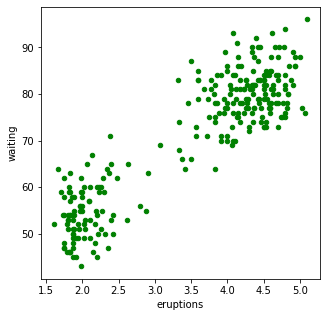

In [ ]:
print(faithful_data.head())
ax1 = faithful_data.plot.scatter(x='eruptions', y='waiting',c='Green', figsize=(5,5))

Data is normalized by subtracting mean and dividing by standard deviation, this corresponds well to the figure in Murphy

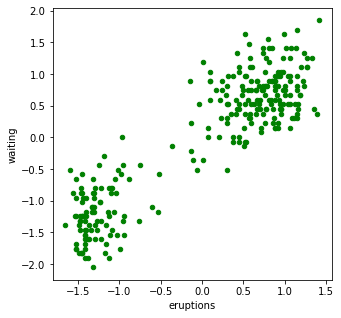

In [ ]:
faithful_norm=(faithful_data-faithful_data.mean())/faithful_data.std()
ax2 = faithful_norm.plot.scatter(x='eruptions', y='waiting',c='Green', figsize=(5,5))

In [ ]:
# NP array from pd df
faithful_norm=np.array(faithful_norm)

$$r_{\mu k}=\frac{\pi_k\mathcal{N}(\mathbf{x}^{\mu}\mid\boldsymbol{\mu}_{k}, \boldsymbol\Sigma_{k})}{\sum_{k'}\pi_{k'}\mathcal{N}(\mathbf{x}^{\mu}\mid\boldsymbol{\mu}_{k'}, \mathbf{\Sigma}_{k'})}$$

E step

In [ ]:
def E(x_data, mu, sigma, mix_weights):
  r = np.zeros(x_data.shape)
  for m, x in enumerate(x_data):
    for k, mix_weight in enumerate(mix_weights):
        r[m,k] = mix_weight*multivariate_normal.pdf(x,mu[k],sigma[k])
    r[m]=r[m]/np.sum(r[m])
  return r

M step

In [ ]:
def M(x_data, mu, sigma, mix_weights, r):
  r_k=np.sum(r,axis=0)
  # Find pi_k vector
  mix_weights = r_k/r.shape[0]

  for k in range(r.shape[1]):
    # Find mu_k vector
    mu[k]= np.sum((r[:,k]*x_data.T).T,axis=0)/r_k[k]
    
    for i,j in np.ndindex(sigma[k].shape):
      # Find sigma_k matrix
      sigma[k,i,j]=np.sum(r[:,k]*x_data[:,i]*x_data[:,j],axis=0)/r_k[k]-mu[k,i]*mu[k,j]
        
  return mu, sigma, mix_weights

$$
    f(x,y) =
      \frac{1}{2 \pi  \sigma_X \sigma_Y \sqrt{1-\rho^2}}
      \exp\left(
        -\frac{1}{2(1-\rho^2)}\left[
          \frac{(x-\mu_X)^2}{\sigma_X^2} +
          \frac{(y-\mu_Y)^2}{\sigma_Y^2} -
          \frac{2\rho(x-\mu_X)(y-\mu_Y)}{\sigma_X \sigma_Y}
        \right]
      \right)
$$

Bivariate normal

In [ ]:
def bivariate_normal(X, Y, sigmax=1.0, sigmay=1.0, mux=0.0, muy=0.0, sigmaxy=0.0):
    Xmu = X-mux
    Ymu = Y-muy
    rho = sigmaxy/(sigmax*sigmay)
    z = Xmu**2/sigmax**2 + Ymu**2/sigmay**2 - 2*rho*Xmu*Ymu/(sigmax*sigmay)
    denom = 2*np.pi*sigmax*sigmay*np.sqrt(1-rho**2)
    return np.exp(-z/(2*(1-rho**2))) / denom

In [ ]:
def plot_gaussians(x_data, mu, sigma, mix_weights, r, assign):
  x_grid = np.linspace(-2, 2, 50)
  y_grid = np.linspace(-2, 2, 50)
  xx, yy = np.meshgrid(x_grid, y_grid)

  # Colour depending on assignment
  c=['red','blue']

  cmap=[]
  if assign:
    for point in (r[:,0]>0.5):
      if point:
        cmap.append(c[0])
      else:
        cmap.append(c[1])
    plt.scatter(x_data[:,0], x_data[:,1],c=cmap)
  else:
    plt.scatter(x_data[:,0], x_data[:,1],c='LightGreen')

  for k,_ in enumerate(mix_weights):
    # Plot gaussian contour circles
    zz = bivariate_normal(xx, yy, np.sqrt(sigma[k,0,0]), np.sqrt(sigma[k,1,1]), mu[k,0], mu[k,1], sigma[k,0,1])
    plt.contour(xx, yy, zz, 1, colors=c[k],linewidths=3)

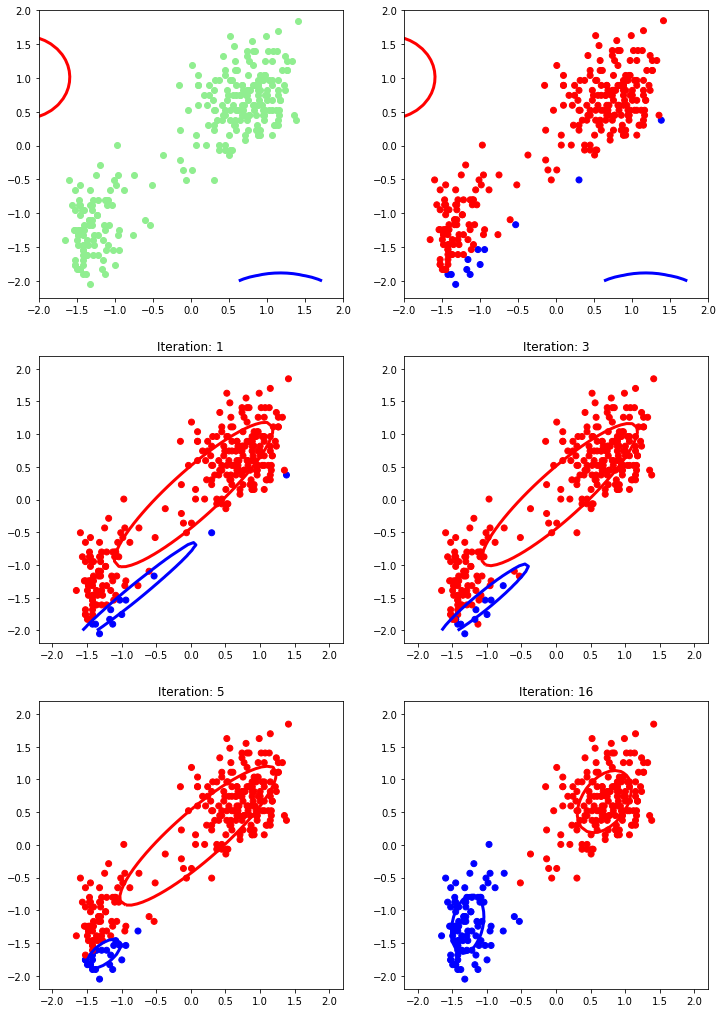

In [ ]:
# Initialize parameters
mu = np.array([[-1.5, 1.5], [1.5, -1.5]])+1*np.random.randn(2,2)
sigma = np.array([0.25 * np.eye(2), 0.25 * np.eye(2)])
mix_weights = np.array([0.5, 0.5])

# Plot first two figures
fig=plt.figure(figsize=[12, 18])
ax = fig.add_subplot(3, 2, 1)
r = E(faithful_norm, mu, sigma, mix_weights)
plot_gaussians(faithful_norm, mu, sigma, mix_weights, r, assign=False)
ax = fig.add_subplot(3, 2, 2)
plot_gaussians(faithful_norm, mu, sigma, mix_weights, r, assign=True)

epochs = 16

# Plot figure only at these iterations, like in murphy
iters=[1,3,5,16]
for i in range(epochs):

  # E step
  r = E(faithful_norm, mu, sigma, mix_weights)
  # M step
  mu, sigma, mix_weights = M(faithful_norm, mu, sigma, mix_weights, r)

  # Plots
  if (i+1) in iters:
    ax = fig.add_subplot(3, 2, 3+iters.index(i+1))
    ax.title.set_text("Iteration: "+str(i+1))
    plot_gaussians(faithful_norm, mu, sigma, mix_weights, r, assign=True)
    plt.xlim(-2.2, 2.2)
    plt.ylim(-2.2, 2.2)